In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
import random
import time
import glob
from tqdm import tqdm

In [4]:
# Define the device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


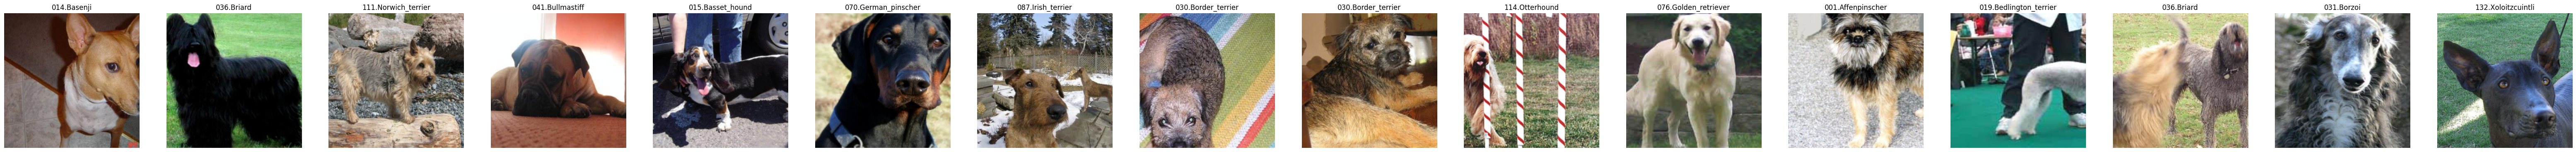

In [8]:
#set the batch size
batch_size = 16

#Data path
imagePath = '/Users/wanghuanqin/Desktop/ConstructionManagement/DeepLearningInComputerVision/DeepL_Final/dogImages'

#Data transformation

data_transforms_dict = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    
    'valid': transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    
    'test': transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    
    'prediction': transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
}

#load data
image_datasets = {x: datasets.ImageFolder(os.path.join(imagePath, x), data_transforms_dict[x]) 
                  for x in ['train', 'valid', 'test']}

#Dataloader
loaders_scratch = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
    for x in ['train', 'valid', 'test']
}

# Get a batch of training data
inputs, classes = next(iter(loaders_scratch['train']))
classes_names = image_datasets['train'].classes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

num_images = len(inputs)  # 获取图像数量
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, 5))  # 创建一个 subplot 行，每个图像一个 subplot

for i, (image, label) in enumerate(zip(inputs, classes)):
    image = image.to("cpu").clone().detach()  # 将图像移动到 CPU
    image = image.numpy().squeeze()  # 转换为 NumPy 数组并去掉不必要的维度
    image = image.transpose(1, 2, 0)  # 转置维度以适应 matplotlib 的显示格式
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))  # 反归一化
    image = image.clip(0, 1)  # 限制图像值在 0 到 1 之间

    ax = axes[i] if num_images > 1 else axes  # 获取当前 subplot 的轴对象
    ax.imshow(image)  # 在当前轴上显示图像
    ax.set_title(classes_names[label])  # 设置标题为类别名称
    ax.axis('off')  # 关闭坐标轴显示

plt.show()  # 显示整个图形


In [9]:
train_images = len(image_datasets['train'])
valid_images = len(image_datasets['valid'])
test_images = len(image_datasets['test'])

print("Number of images in train dataset:", train_images)
print("Number of images in valid dataset:", valid_images)
print("Number of images in test dataset:", test_images)

Number of images in train dataset: 19975
Number of images in valid dataset: 835
Number of images in test dataset: 836


In [4]:
try:
    ImageFile.LOAD_TRUNCATED_IMAGES = True
except:
    pass


def train_model(n_epochs, loaders, model, optimizer, scheduler, criterion, device, save_path):

    scheduler = scheduler
    train_loss_history = []
    valid_loss_history = []
    train_acc_history = []
    valid_acc_history = []
    learning_rate_history = []

    best_acc = 0.0
    for epoch in range(1, n_epochs + 1):
        print('-' * 10)
        print(f'Epoch {epoch }/{n_epochs}')
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0

            #iterate over data
            for data, target in loaders[phase]:
                data, target = data.to(device), target.to(device)
                #zero the parameter gradients
                optimizer.zero_grad()

                #forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    output = model(data)
                    loss = criterion(output, target)
                    _, preds = torch.max(output, 1)
                    #backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                #statistics
                running_loss += loss.item() * data.size(0)
                running_corrects += torch.sum(preds == target.data)

            if phase == 'train':
                scheduler.step()
            # epoch_loss = np.mean(running_loss)
            # epoch_acc = np.mean(running_corrects)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss = epoch_loss
                train_acc = epoch_acc.cpu().numpy()
            else:
                valid_loss = epoch_loss
                valid_acc = epoch_acc.cpu().numpy()

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print("Current learning rate; ", optimizer.param_groups[0]['lr'])

        
        #save the model if validation loss has decreased
        if phase == 'valid' and epoch_acc >= best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), save_path)
        
        
                    
        # Append histories after converting to normal Python types or ensuring they are on CPU
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        train_acc_history.append(train_acc)
        valid_acc_history.append(valid_acc)
        learning_rate_history.append(optimizer.param_groups[0]['lr'])

    #save the model_metrics    
    model_metrics = {
        'train_loss_history': train_loss_history,
        'valid_loss_history': valid_loss_history,
        'train_acc_history': train_acc_history,
        'valid_acc_history': valid_acc_history,
        'learning_rate_history': learning_rate_history
    }
    return model, model_metrics

def plotting(input_metric, input_metric_name):
    
    
    fig, arg = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(input_metric_name, fontsize=16)
    # Plot for Learning Rate
    arg[0].plot(np.array(input_metric['learning_rate_history']), label='learning rate')
    arg[0].set_title('Learning Rate')
    arg[0].set_xlabel('Epoch')

    # Plot for loss
    arg[1].plot(np.array(input_metric['train_loss_history']), label='Training Loss')
    arg[1].plot(np.array(input_metric['valid_loss_history']), label='Validation Loss')
    arg[1].set_title('Loss')
    arg[1].set_xlabel('Epoch')
    arg[1].set_ylabel('loss')
    arg[1].legend()

    # Plot for accuracy
    arg[2].plot(np.array(input_metric['train_acc_history']), label='Training Accuracy')
    arg[2].plot(np.array(input_metric['valid_acc_history']), label='Validation Accuracy')
    arg[2].set_title('Accuracy')
    arg[2].set_xlabel('Epoch')
    arg[2].set_ylabel('acc')
    arg[2].legend()

    plt.show()

def load_model(model_path, model, device):
    """
    Load the trained model from a file.
    """
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    return model


def test_model(model_path, model, criterion, test_loader, device, show_images=False, images_per_figure=10):
    """
    Test the trained model with the provided test loader and optionally display images.
    """
    model = load_model(model_path, model, device)
    model.eval()  # Set model to evaluation mode
    
    test_loss = 0.0
    all_preds = []
    all_targets = []
    class_names = classes_names

    # Initialize for image display
    if show_images:
        fig, axes = None, None
        current_image_count = 0

    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)

            _, preds = torch.max(output, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

            if show_images:
                # Prepare to display images
                if current_image_count % images_per_figure == 0:
                    if fig is not None:
                        plt.tight_layout()
                        plt.show()
                    # Calculate columns needed for the current set of images
                    num_images_remaining = len(test_loader.dataset) - current_image_count
                    cols = min(images_per_figure, num_images_remaining)
                    fig, axes = plt.subplots(nrows=1, ncols=cols, figsize=(cols * 2, 2))  # Adjusted figsize
                    if cols == 1:
                        axes = [axes]  # Ensure axes is iterable
                    
                ax = axes[current_image_count % images_per_figure]

                image = data.cpu().data[0].permute(1, 2, 0).numpy()
                image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
                image = np.clip(image, 0, 1)
                ax.imshow(image)
                ax.set_title(f'Predicted: {class_names[preds[0]]}')
                ax.axis('off')
                current_image_count += 1

    if show_images and fig is not None:
        plt.tight_layout()
        plt.show()

    # Calculate average loss and accuracy
    test_loss /= len(test_loader.dataset)
    accuracy = np.mean(np.array(all_preds) == np.array(all_targets))

    # Compute confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    
    test_metrics = {
        'test_loss': test_loss,
        'accuracy': accuracy,
        'confusion_matrix': cm
    }

    return test_metrics

def plot_confusion_matrix(model_metric, class_names, model_name):
    """
    Plot the confusion matrix using seaborn and matplotlib.
    """
    plt.figure(figsize=(5, 4))
    sns.heatmap(model_metric['confusion_matrix'], annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('From %s (Acc: %.4f%%)' % (model_name, model_metric['accuracy']*100))
    plt.show()

In [16]:
class DogBreedResNet(nn.Module):
    def __init__(self, num_classes):
        super(DogBreedResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual blocks
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        # Classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = self.relu(out)

        return out

class DogBreedResNetFeatureExtractor(nn.Module):
    def __init__(self, pretrained_model):
        super(DogBreedResNetFeatureExtractor, self).__init__()
        # Keep all parts of the pretrained model except the final fully connected layer
        self.features = nn.Sequential(
            *list(pretrained_model.children())[:-1]  # Remove the last layer
        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten the features into a vector
        return x
    


class HybridModel(nn.Module):
    def __init__(self, num_classes):
        super(HybridModel, self).__init__()
        self.dog_breed_resnet = DogBreedResNet(num_classes)
        

        self.resnet18 = models.resnet18(weights = models.ResNet18_Weights.DEFAULT)


        # Classifier to combine features
        # Assuming each network outputs 512 features
        # self.classifier = nn.Linear(133 + 133, num_classes)
        self.combined_features_size = 133 + 133  # Adjust accordingly if different
        self.classifier = nn.Sequential(
            nn.Linear(self.combined_features_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        features1 = self.dog_breed_resnet(x)
        features2 = self.resnet18(x)
        
        # Concatenate features along the feature dimension
        combined_features = torch.cat((features1, features2), dim=1)
        
        # Pass the combined features through the final classifier
        output = self.classifier(combined_features)
        return output
    
class ensemble_model(nn.Module):
    def __init__(self, model1, model2, model3):
        super().__init__()
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3

        self.combined_features_size = 133 * 3

        self.classifier = nn.Sequential(
            nn.Linear(self.combined_features_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 133)
        )
    def forward(self, x):
        features1 = self.model1(x)
        features2 = self.model2(x)
        features3 = self.model3(x)
        
        # Concatenate features along the feature dimension
        combined_features = torch.cat((features1, features2, features3), dim=1)
        
        # Pass the combined features through the final classifier
        output = self.classifier(combined_features)
        return output

In [11]:
desnet = models.densenet201(weights=models.DenseNet201_Weights.DEFAULT)
for param in desnet.parameters():
    param.requires_grad = False
desnet.classifier = nn.Linear(desnet.classifier.in_features, out_features=133)
desnet.to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(desnet.parameters(), lr = 0.001, weight_decay=1e-2, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

num_epoch = 50
# Train the model
print("Start Training model from scratch")
desnet, desnet_metric = train_model(num_epoch, loaders_scratch, desnet, optimizer, scheduler, criterion, device, '/home/melson/DeepL_Final/model_pt/desnet201_bs16.pt')


Start Training model from scratch
----------
Epoch 1/50
train Loss: 2.7480 Acc: 0.4976
valid Loss: 2.2577 Acc: 0.5102
Current learning rate;  0.001
----------
Epoch 2/50
train Loss: 1.6065 Acc: 0.6654
valid Loss: 1.6317 Acc: 0.5868
Current learning rate;  0.001
----------
Epoch 3/50
train Loss: 1.3660 Acc: 0.6937
valid Loss: 1.4331 Acc: 0.6156
Current learning rate;  0.001
----------
Epoch 4/50
train Loss: 1.2561 Acc: 0.7157
valid Loss: 1.2827 Acc: 0.6683
Current learning rate;  0.001
----------
Epoch 5/50
train Loss: 1.1773 Acc: 0.7323
valid Loss: 1.2660 Acc: 0.6850
Current learning rate;  0.001
----------
Epoch 6/50
train Loss: 1.1566 Acc: 0.7318
valid Loss: 1.1997 Acc: 0.6886
Current learning rate;  0.001
----------
Epoch 7/50
train Loss: 1.1248 Acc: 0.7443
valid Loss: 1.1372 Acc: 0.6970
Current learning rate;  0.001
----------
Epoch 8/50
train Loss: 1.1151 Acc: 0.7450
valid Loss: 1.1437 Acc: 0.7162
Current learning rate;  0.001
----------
Epoch 9/50
train Loss: 1.0913 Acc: 0.7502
v

In [12]:
vgg19 = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
for param in vgg19.parameters():
    param.requires_grad = False
vgg19.classifier[6] = nn.Linear(vgg19.classifier[6].in_features, 133)
vgg19.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg19.parameters(), lr = 0.001, weight_decay=1e-2, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

num_epoch = 25
# Train the model
print("Start Training model from scratch")
vgg19, vgg19_metric = train_model(num_epoch, loaders_scratch, vgg19, optimizer, scheduler, criterion, device, '/home/melson/DeepL_Final/model_pt/vgg19_bs16.pt')


Start Training model from scratch
----------
Epoch 1/25
train Loss: 1.5072 Acc: 0.6446
valid Loss: 1.1583 Acc: 0.6659
Current learning rate;  0.001
----------
Epoch 2/25
train Loss: 1.0424 Acc: 0.7181
valid Loss: 1.0498 Acc: 0.7018
Current learning rate;  0.001
----------
Epoch 3/25
train Loss: 0.9669 Acc: 0.7301
valid Loss: 0.9191 Acc: 0.7389
Current learning rate;  0.001
----------
Epoch 4/25
train Loss: 0.9441 Acc: 0.7369
valid Loss: 0.9920 Acc: 0.7210
Current learning rate;  0.001
----------
Epoch 5/25
train Loss: 0.9481 Acc: 0.7364
valid Loss: 0.9356 Acc: 0.7317
Current learning rate;  0.0001
----------
Epoch 6/25
train Loss: 0.8849 Acc: 0.7531
valid Loss: 0.9193 Acc: 0.7293
Current learning rate;  0.0001
----------
Epoch 7/25
train Loss: 0.8831 Acc: 0.7560
valid Loss: 0.9061 Acc: 0.7473
Current learning rate;  0.0001
----------
Epoch 8/25
train Loss: 0.8622 Acc: 0.7633
valid Loss: 0.9471 Acc: 0.7401
Current learning rate;  0.0001
----------
Epoch 9/25
train Loss: 0.8522 Acc: 0.76

In [13]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for param in resnet18.parameters():
    param.requires_grad = False
resnet18.fc = nn.Linear(resnet18.fc.in_features, 133)
resnet18.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr = 0.001, weight_decay=1e-2, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

num_epoch = 25
# Train the model
print("Start Training model from scratch")
resnet18, resnet18_metric = train_model(num_epoch, loaders_scratch, resnet18, optimizer, scheduler, criterion, device, '/home/melson/DeepL_Final/model_pt/resnet18_bs16.pt')



Start Training model from scratch
----------
Epoch 1/25
train Loss: 3.0535 Acc: 0.3952
valid Loss: 2.5604 Acc: 0.4515
Current learning rate;  0.001
----------
Epoch 2/25
train Loss: 1.9869 Acc: 0.5743
valid Loss: 2.0416 Acc: 0.5102
Current learning rate;  0.001
----------
Epoch 3/25
train Loss: 1.7235 Acc: 0.6082
valid Loss: 1.7372 Acc: 0.5341
Current learning rate;  0.001
----------
Epoch 4/25
train Loss: 1.6066 Acc: 0.6262
valid Loss: 1.6096 Acc: 0.5677
Current learning rate;  0.001
----------
Epoch 5/25
train Loss: 1.5461 Acc: 0.6364
valid Loss: 1.5566 Acc: 0.5832
Current learning rate;  0.0001
----------
Epoch 6/25
train Loss: 1.4717 Acc: 0.6579
valid Loss: 1.4485 Acc: 0.6024
Current learning rate;  0.0001
----------
Epoch 7/25
train Loss: 1.4645 Acc: 0.6580
valid Loss: 1.5240 Acc: 0.5796
Current learning rate;  0.0001
----------
Epoch 8/25
train Loss: 1.4732 Acc: 0.6592
valid Loss: 1.4871 Acc: 0.5808
Current learning rate;  0.0001
----------
Epoch 9/25
train Loss: 1.4694 Acc: 0.65

In [17]:

num_classes = 133
desnet = load_model('/home/melson/DeepL_Final/model_pt/desnet201_bs16.pt', desnet, device)
vgg19 = load_model('/home/melson/DeepL_Final/model_pt/vgg19_bs16.pt', vgg19, device)
resnet18 = load_model('/home/melson/DeepL_Final/model_pt/resnet18_bs16.pt',resnet18, device)

ensemble_dawg = ensemble_model(desnet, vgg19, resnet18)
for param in ensemble_dawg.parameters():
    param.requires_grad = False

for param in ensemble_dawg.classifier.parameters():
    param.requires_grad = True

ensemble_dawg.to(device)


ensemble_model(
  (model1): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, moment

In [29]:
# Assuming you have some dummy input data `dummy_input` of the correct size
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Example size for a typical image input

ensemble_dawg.model1.eval()
ensemble_dawg.model2.eval()
ensemble_dawg.model3.eval()
ensemble_dawg.eval()

# Pass the dummy input through each model
output1 = ensemble_dawg.model1(dummy_input)
output2 = ensemble_dawg.model2(dummy_input)
output3 = ensemble_dawg.model3(dummy_input)
output = ensemble_dawg(dummy_input)

print("Output shape from model1:", output1.shape)
print("Output shape from model2:", output2.shape)
print("Output shape from model2:", output3.shape)
print("Output shape from model2:", output.shape)

Output shape from model1: torch.Size([1, 133])
Output shape from model2: torch.Size([1, 133])
Output shape from model2: torch.Size([1, 133])
Output shape from model2: torch.Size([1, 133])


In [22]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ensemble_dawg.parameters(), lr = 0.01, weight_decay=1e-2, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

num_epoch = 50
# Train the model
print("Start Training model from scratch")
model_scratch, metric_scratch = train_model(num_epoch, loaders_scratch, ensemble_dawg, optimizer, scheduler, criterion, device, '/home/melson/DeepL_Final/model_pt/ensemble_model_bs16.pt')


Start Training model from scratch
----------
Epoch 1/50
train Loss: 8.0493 Acc: 0.3998
valid Loss: 17.1052 Acc: 0.3940
Current learning rate;  0.01
----------
Epoch 2/50
train Loss: 20.6554 Acc: 0.3602
valid Loss: 19.0471 Acc: 0.4180
Current learning rate;  0.01
----------
Epoch 3/50
train Loss: 16.5875 Acc: 0.3718
valid Loss: 17.2068 Acc: 0.4275
Current learning rate;  0.01
----------
Epoch 4/50
train Loss: 13.5855 Acc: 0.3737
valid Loss: 10.8576 Acc: 0.4335
Current learning rate;  0.01
----------
Epoch 5/50
train Loss: 8.7045 Acc: 0.3865
valid Loss: 10.1570 Acc: 0.4407
Current learning rate;  0.005
----------
Epoch 6/50
train Loss: 2.4710 Acc: 0.5647
valid Loss: 1.3652 Acc: 0.6443
Current learning rate;  0.005
----------
Epoch 7/50
train Loss: 1.5591 Acc: 0.6201
valid Loss: 1.3215 Acc: 0.6587
Current learning rate;  0.005
----------
Epoch 8/50
train Loss: 1.4101 Acc: 0.6300
valid Loss: 1.2749 Acc: 0.6407
Current learning rate;  0.005
----------
Epoch 9/50
train Loss: 1.3613 Acc: 0.63

In [32]:
ensemble_dawg = load_model('/home/melson/DeepL_Final/model_pt/ensemble_model_bs16.pt', ensemble_dawg, device)
for param in ensemble_dawg.parameters():
    param.requires_grad = False

for param in ensemble_dawg.classifier.parameters():
    param.requires_grad = True
ensemble_dawg.to(device)
test = test_model('/home/melson/DeepL_Final/model_pt/ensemble_model_bs16.pt', ensemble_dawg, criterion, loaders_scratch['test'], device, False)
print('test loss: %f, accuracy: %.3f%%' % (test['test_loss'], test['accuracy']*100) )

test loss: 0.866404, accuracy: 75.718%
